In [1]:
'''
loading libs
'''
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
loading images
'''
nevus_filepath = 'data/0/'
melanoma_filepath = 'data/1/'

nevus_files = [f for f in os.listdir(nevus_filepath) if os.path.isfile(nevus_filepath+f)]
melanoma_files = [f for f in os.listdir(melanoma_filepath) if os.path.isfile(melanoma_filepath+f)]
# sort filenames
nevus_files = sorted(nevus_files)
melanoma_files = sorted(melanoma_files)

N = 1000
nevus_imgs = [plt.imread(os.path.join(nevus_filepath, nevus_files[i])) for i in range(N)]
melanoma_imgs = [plt.imread(os.path.join(melanoma_filepath, melanoma_files[i])) for i in range(N)]

ish = (224,224)

# resize
nevus_imgs = [cv2.resize(img,(ish[0],ish[1])) for img in nevus_imgs]
melanoma_imgs = [cv2.resize(img,(ish[0],ish[1])) for img in melanoma_imgs]

nevus_imgs = np.array(nevus_imgs)
melanoma_imgs = np.array(melanoma_imgs)


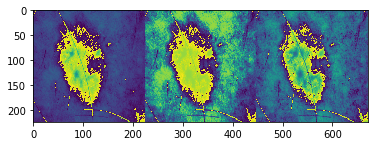

In [3]:
all_imgs = nevus_imgs + melanoma_imgs
img = all_imgs[11]
equ = cv2.equalizeHist(img)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)

res = np.hstack((img,equ,cl1))

plt.imshow(res, vmax=255,vmin=0)
plt.show()


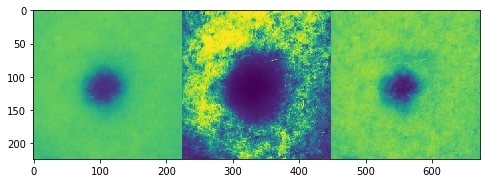

KeyboardInterrupt: 

In [113]:
'''
Create some labals
'''
from IPython.display import clear_output

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def create_labels(path):

    labels = []
    path = path + '/'
    val_for = ['jpg', 'jpeg', 'png']
    img_list = os.listdir(path)
    img_list = [i for i in img_list if i.split('.')[-1] in val_for]
    
    for i in img_list:
        img = plt.imread(path + i)
        img = cv2.resize(img, (ish[0],ish[1]))
        
        equ = cv2.equalizeHist(img)
        cl1 = clahe.apply(img)

        res = np.hstack((img,equ,cl1))

        plt.figure(figsize=(8,4))
        plt.imshow(res, vmax=255,vmin=0)
        plt.show()
        
        inp = input()
        labels.append(int(inp))
        clear_output(wait=True)
        
    data = {'Image':img_list, 'Label':labels}
    df = pd.DataFrame(data)
    df.to_csv('labels.csv') 
    
    print('\nlabels.csv saved!')
    return (df)

l = create_labels(nevus_filepath)

In [4]:
import tensorflow

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

tensorflow.debugging.set_log_device_placement(True)
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpus[0], True)

1.15.2
Num GPUs Available:  1


In [5]:
# MobileNet - 10 clusters
# ResNet50
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights='imagenet', include_top=False, input_shape=(ish[0],ish[1],3))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_c

In [6]:
feature_list = []

for img in all_imgs:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) / 255
    img_rgb = np.expand_dims(img_rgb, axis=0)

    features = model.predict(img_rgb)
    
    feature_list += [features.flatten()]


In [92]:
'''
DBSCAN
'''
from sklearn.cluster import DBSCAN

epsilon = 46
min_points = 3

db = DBSCAN(eps=epsilon, min_samples=min_points, n_jobs=-1).fit(feature_list)


core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

classes = labels

Estimated number of clusters: 1
Estimated number of noise points: 380


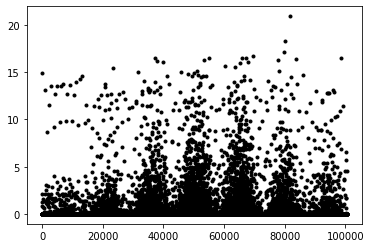

In [71]:
plt.plot(feature_list[42], 'k.')

In [9]:
'''
K-MEANS
'''
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []
kmin = 2
kmax = 20

# Maximum optinal
for k in range(kmin, kmax+1):
    print(k,end='')
    kmean = KMeans(n_clusters=k, random_state=0, n_jobs=-1).fit(feature_list)
    labels = kmean.labels_
    sil.append(silhouette_score(feature_list, labels, metric = 'euclidean'))

2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 

In [43]:
'''
Hierarchical clustering
'''
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=2).fit(feature_list)
classes = clustering.labels_


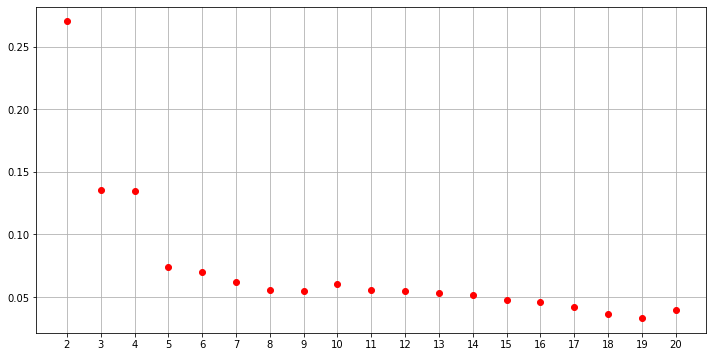

In [10]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(kmin,kmax+1), sil, 'ro')
plt.xticks(np.arange(kmin,kmax+1).tolist())
plt.grid()

In [70]:
# kmean = KMeans(n_clusters=7, random_state=0, n_jobs=-1).fit(feature_list)
# classes = kmean.labels_
classes

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

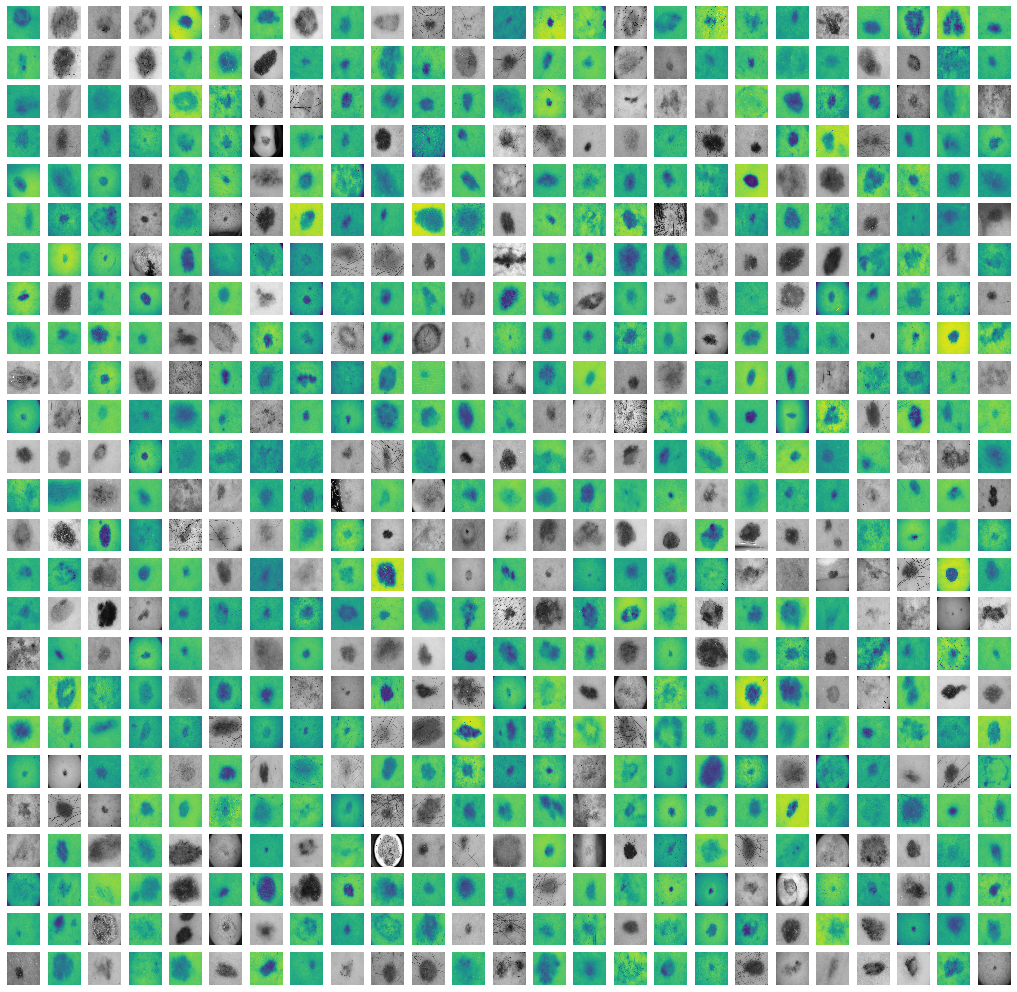

In [95]:
size = (25,25)

fig, ax = plt.subplots(size[0], size[1], figsize=(18,18))
k = 0
for x in range(size[0]):
    for y in range(size[1]):
        if classes[k] == -1:
            ax[x,y].imshow(nevus_imgs[k], 'gray', vmax=255,vmin=0)
            
        if classes[k] == 0:
            ax[x,y].imshow(nevus_imgs[k], vmax=255,vmin=0)
        if classes[k] == 1:
            ax[x,y].imshow(nevus_imgs[k], 'Blues', vmax=255,vmin=0)
        if classes[k] == 2:
            ax[x,y].imshow(nevus_imgs[k], 'Greens', vmax=255,vmin=0)
        if classes[k] == 3:
            ax[x,y].imshow(nevus_imgs[k], 'Oranges', vmax=255,vmin=0)
        if classes[k] == 4:
            ax[x,y].imshow(nevus_imgs[k], 'Purples', vmax=255,vmin=0)
        if classes[k] == 5:
            ax[x,y].imshow(nevus_imgs[k], '', vmax=255,vmin=0)
        if classes[k] == 6:
            ax[x,y].imshow(nevus_imgs[k], 'hot', vmax=255,vmin=0)
        if classes[k] == 7:
            ax[x,y].imshow(nevus_imgs[k], 'cool', vmax=255,vmin=0)
        if classes[k] == 8:
            ax[x,y].imshow(nevus_imgs[k], 'pink', vmax=255,vmin=0)
        if classes[k] == 9:
            ax[x,y].imshow(nevus_imgs[k], 'spring', vmax=255,vmin=0)
        ax[x,y].axis('off')
        k+=1

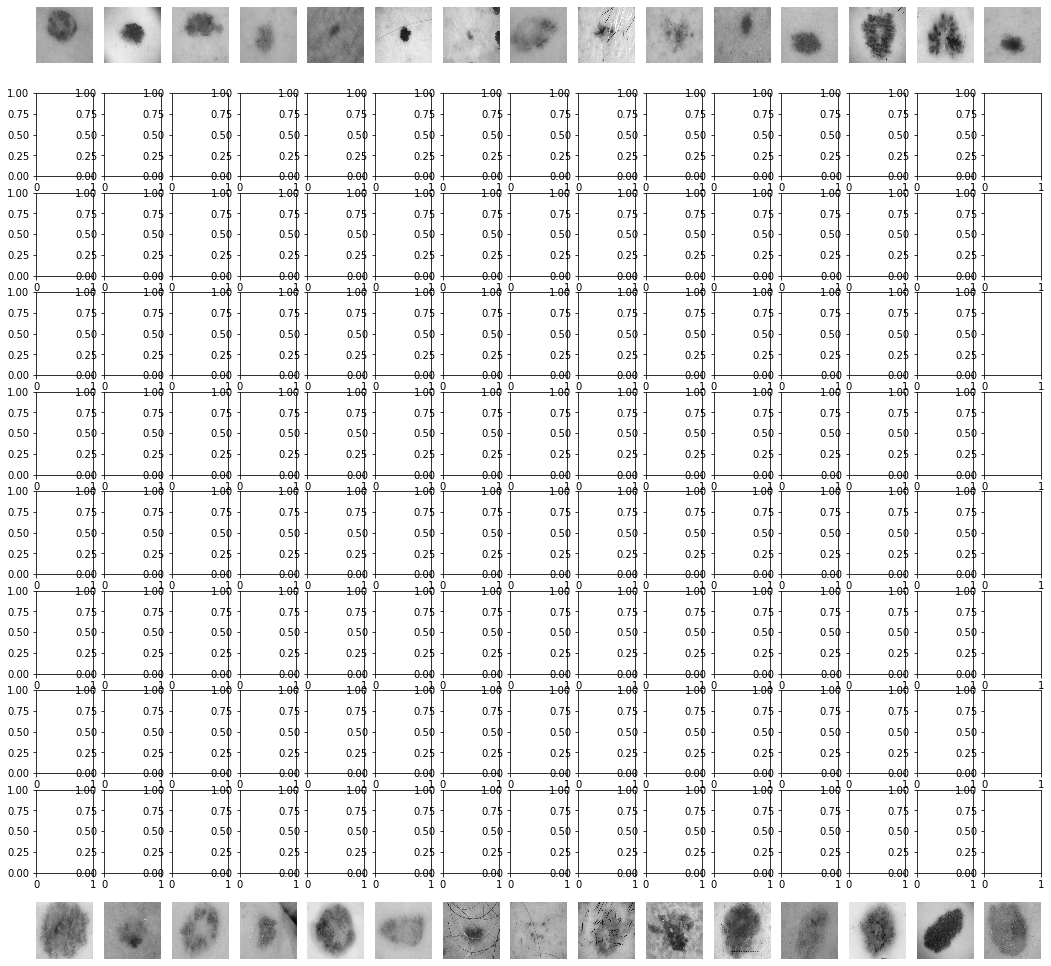

In [94]:
size = (10, 15)
counter = np.zeros(size[1])

fig, ax = plt.subplots(size[0], size[1], figsize=(18,18))

for k in range(len(nevus_imgs)):
    x = int(classes[k])
    y = int(counter[x])
    
    counter[x] += 1
    if counter[x] <= size[1]:
        ax[x,y].imshow(nevus_imgs[k], 'gray', vmax=255,vmin=0)
        ax[x,y].axis('off')



In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3).fit(feature_list)
reduced_data = pca.transform(feature_list)


In [66]:
from sklearn.manifold import TSNE
reduced_data = TSNE(n_components=3, n_jobs=-1).fit_transform(feature_list)


In [93]:
import plotly.graph_objects as go
N = 7
x = []
# for n in range(N):

x0 = go.Scatter3d(x=reduced_data[classes==-1,0], 
                     y=reduced_data[classes==-1,1], 
                     z=reduced_data[classes==-1,2], 
                    mode='markers', name='x0', 
                    marker=dict(
                        color='#111111',
                        size=3,
                        opacity=0.3))

x1 = go.Scatter3d(x=reduced_data[classes==0,0], 
                    y=reduced_data[classes==0,1], 
                    z=reduced_data[classes==0,2], 
                    mode='markers', name='x1', 
                    marker=dict(
                        color='#ff0000',
                        size=3,
                        opacity=0.9))

x2 = go.Scatter3d(x=reduced_data[classes==1,0], 
                     y=reduced_data[classes==1,1], 
                     z=reduced_data[classes==1,2], 
                    mode='markers', name='x2', 
                    marker=dict(
                        color='#00ff00',
                        size=3,
                        opacity=0.9))

x3 = go.Scatter3d(x=reduced_data[classes==2,0], 
                    y=reduced_data[classes==2,1], 
                    z=reduced_data[classes==2,2], 
                    mode='markers', name='x3', 
                    marker=dict(
                        color='#0000ff',
                        size=3,
                        opacity=0.9))

# x4 = go.Scatter3d(x=reduced_data[classes==3,0], 
#                     y=reduced_data[classes==3,1], 
#                     z=reduced_data[classes==3,2], 
#                     mode='markers', name='x4', 
#                     marker=dict(
#                         color='rgb(200,200,0)',
#                         size=3,
#                         opacity=0.9))

fig = go.Figure(data=[x0, x1, x2])
fig.show()